In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import copy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.9.0+cu102


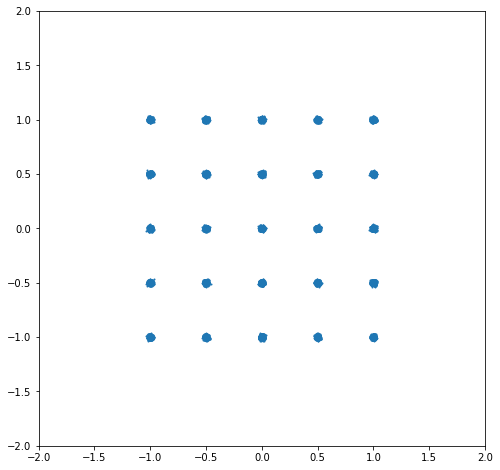

In [2]:
class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self):

        num_data = 50000
        num_class = 25

        y = [[i] * (num_data //num_class) for i in range(num_class)]
        y = np.array(y, dtype=np.int64).reshape(-1)
        x = np.random.randn(num_data, 2) * 0.01
        for i in range(num_data):
            x[i] += [-1 + (2 / 4) * (y[i] // 5), -1 + (2 / 4) * (y[i] % 5)]
        y = np.array(y, dtype=np.int64)

        self.x = x
        self.y = y


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]



dataset = CustomDataSet()

plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.scatter(dataset.x[:, 0], dataset.x[:, 1], s=1)
plt.show()


In [3]:
class IGEBM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Linear(2, 32)
        self.net2 = nn.Linear(32, 32)
        self.net3 = nn.Linear(32, 32)
        self.net4 = nn.Linear(32, 32)
        self.net5 = nn.Linear(32, 32)
        self.net6 = nn.Linear(32, 32)
        self.net7 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.net1(x)
        x = x.sigmoid() * x
        x = x + self.net2(x)
        x = x.sigmoid() * x
        x = x + self.net3(x)
        x = x.sigmoid() * x
        x = x + self.net4(x)
        x = x.sigmoid() * x
        x = x + self.net5(x)
        x = x.sigmoid() * x
        x = x + self.net6(x)
        x = x.sigmoid() * x
        return self.net7(x)
    


In [7]:
class ChainBuffer(object):
    def __init__(self, size, shape):
        self.size = size
        self.shape = shape
        self.queue = deque(maxlen=self.size)

    def __len__(self):
        return len(self.queue)

    def push(self, imgs):
        for img in imgs:
            self.queue.append(img)

    def get(self, batch_size):
        return [np.stack(x) for x in random.sample(self.queue, batch_size)]

    def sample(self, batch_size, init_prob=0.05):

        num_gets = 0
        if len(self) > 0:
            num_gets = np.random.binomial(min(len(self), batch_size), 1. - init_prob)
    
        data, is_init = None, []

        if num_gets > 0:
            data = np.array(self.get(num_gets))
            is_init += [False for _ in range(num_gets)]

        if batch_size > num_gets:
            shape = (batch_size - num_gets, *self.shape)
            if data is None:
                data = 2. * np.random.rand(*shape) - 1.
            else:
                data = np.concatenate([data, 2. * np.random.rand(*shape) - 1.], axis=0)
            is_init += [True for _ in range(batch_size - num_gets)]
        
        return data, np.array(is_init, dtype=np.bool)



In [15]:
batch_size = 64
lr = 1e-4
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
igebm = IGEBM()
optimizer = optim.Adam(igebm.parameters(), lr=lr)
buffer = ChainBuffer(50000, shape=(2, ))

In [16]:
def langevin_dynamics(x, net, num_steps, step_size):
    for i in range(num_steps):
        net.zero_grad()
        x = x.requires_grad_(True)
        energy = net(x)
        energy.mean().backward()
        x.data -= 0.5 * step_size * step_size * x.grad
        x.data += step_size * torch.randn_like(x)
        x = x.clone().detach()
    return x

In [17]:
for epoch in range(50):
    avg_loss = np.array([0., 0., 0.])

    for x, y in loader:
        x = x.float().to(device)

        optimizer.zero_grad()
        x_neg, is_init = buffer.sample(batch_size)
        x_neg = torch.FloatTensor(x_neg).to(device)

        x_neg = langevin_dynamics(x_neg, igebm, 100, 0.001)
        buffer.push(x_neg.detach().cpu().numpy())


        neg_e = igebm(x_neg)
        pos_e = igebm(x)

        pos_e = pos_e.mean()
        neg_e = neg_e.mean()
        l2_loss = pos_e.pow(2) + neg_e.pow(2)

        loss = pos_e - neg_e + 0.1 * l2_loss

        loss.backward()

        optimizer.step()

        avg_loss += [pos_e.item(), neg_e.item(), l2_loss.item()]

    avg_loss /= len(loader)
    print(avg_loss)

[-2.23340144 -1.74991808 10.56063979]
[-3.57607474 -1.89099137 17.12785392]
[-4.17184255 -1.13072395 20.02914188]
[-4.45980894 -0.6463777  21.90978177]
[-4.53787527 -0.47691281 22.53397064]
[-4.56368821 -0.43039318 22.87395193]
[-4.55765544 -0.45566233 22.73405234]
[-4.60420663 -0.39285689 23.03616056]
[-4.60180069 -0.37662967 23.0492781 ]
[-4.58189467 -0.40634667 22.84561806]
[-4.59475289 -0.38999098 22.99456076]
[-4.58845904 -0.41257422 22.97300712]
[-4.61186601 -0.3879248  23.09895019]
[-4.61583986 -0.37061937 23.12946499]
[-4.590698   -0.39943438 22.88720372]
[-4.62696346 -0.37787203 23.04484052]
[-4.65134875 -0.35972535 23.30577537]
[-4.64988438 -0.37985825 23.18517274]
[-4.67518084 -0.31475483 23.42553655]
[-4.68531838 -0.32693133 23.43538519]
[-4.7012389  -0.29081759 23.5504754 ]
[-4.7084736  -0.31493096 23.58040525]
[-4.69969135 -0.30148787 23.45721608]
[-4.73599221 -0.26951446 23.78587568]
[-4.70902697 -0.26623848 23.59380245]
[-4.70456476 -0.31721655 23.4536049 ]
[-4.71865869

In [21]:
sample = list(buffer.queue)
sample = np.array(sample)
sample = torch.Tensor(sample)
sample = langevin_dynamics(sample, igebm, 2000, 0.0001)

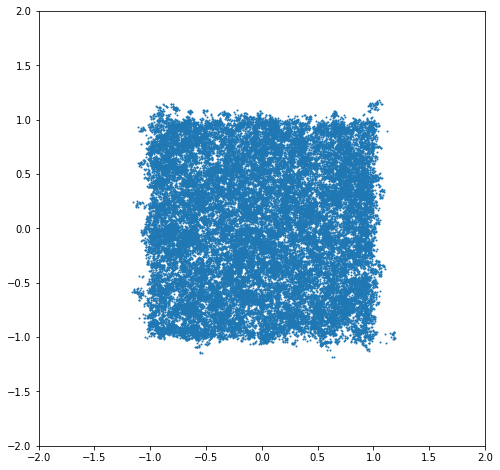

In [22]:
plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
sample = sample.numpy()
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.show()

In [32]:
x = torch.randn(200, 200, 2)
for i in range(200):
    for j in range(200):
        x[i][j][0] = -2.0 + i * (4./200)
        x[i][j][1] = 2.0 - j * (4./200)



In [33]:
y = igebm(x)
print(y.shape)

torch.Size([200, 200, 1])


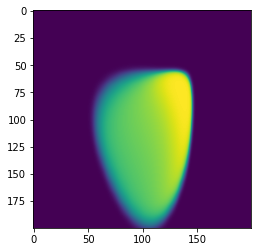

In [35]:
plt.imshow(y.squeeze().sigmoid().detach().numpy())
plt.show()